In [5]:
# Gerekli kütüphaneleri yüklüyoruz.
# 'datasets' SST-2 verisini kolayca çekmek için.
!pip install datasets

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import re
import numpy as np
import os

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device being used: {device}")

# ==========================================
# 2. LOAD DATASET (SST-2)
# ==========================================
print("Loading SST-2 dataset...")
dataset = load_dataset("sst2")
train_data = dataset['train']
val_data = dataset['validation']

# ==========================================
# 3. MANUAL GLOVE DOWNLOAD & LOADING
# ==========================================
# torchtext yerine GloVe'u manuel indiriyoruz (Daha güvenli yöntem)
if not os.path.exists('glove.6B.zip'):
    print("Downloading GloVe embeddings (822 MB)... This may take 1-2 mins.")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip
else:
    print("GloVe files already exist.")

def load_glove_manual(path):
    """
    GloVe dosyasını satır satır okuyup bir sözlüğe çevirir.
    Örnek: 'apple': [0.12, -0.45, ...]
    """
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

print("Loading GloVe vectors into memory...")
# 300 boyutlu vektörleri kullanacağız (Soru 1c isteği)
glove_dict = load_glove_manual('glove.6B.300d.txt')
print(f"Loaded {len(glove_dict)} GloVe vectors.")

# ==========================================
# 4. PREPROCESSING & VOCABULARY
# ==========================================
def tokenizer(text):
    return re.findall(r"\w+", text.lower())

print("Building vocabulary from training data...")
counter = Counter()
for item in train_data:
    counter.update(tokenizer(item['sentence']))

# Vocab oluşturma: Kelime -> ID
# <pad>: Cümle boylarını eşitlemek için boşluk (ID: 0)
# <unk>: Bilinmeyen kelimeler için (ID: 1)
vocab = {'<pad>': 0, '<unk>': 1}
for word, count in counter.items():
    if count > 1:
        vocab[word] = len(vocab)

print(f"Vocabulary size: {len(vocab)}")

# ==========================================
# 5. CREATE EMBEDDING MATRIX
# ==========================================
# Bu matris, modelimizin "sözlüğü" olacak.
# Satır sayısı: Kelime sayımız, Sütun sayısı: 300 (vektör boyutu)
embedding_dim = 300
embedding_matrix = torch.zeros(len(vocab), embedding_dim)
hits = 0

for word, idx in vocab.items():
    if word in glove_dict:
        embedding_matrix[idx] = torch.tensor(glove_dict[word])
        hits += 1
    else:
        # Eğer kelime GloVe'da yoksa (örn: nadir isimler), rastgele başlatılır
        embedding_matrix[idx] = torch.randn(embedding_dim)

print(f"Embedding matrix created. Hits: {hits}/{len(vocab)}")

# ==========================================
# 6. DATA LOADERS
# ==========================================
def collate_batch(batch):
    label_list, text_list = [], []
    for item in batch:
        label_list.append(item['label'])
        # Kelimeleri ID'ye çevir
        processed_text = [vocab.get(token, vocab['<unk>']) for token in tokenizer(item['sentence'])]
        text_list.append(torch.tensor(processed_text, dtype=torch.int64))

    # Pad sequences: Kısa cümlelerin sonuna 0 ekleyerek hepsini aynı boya getir
    label_list = torch.tensor(label_list, dtype=torch.float32)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=vocab['<pad>'])

    return text_list.to(device), label_list.to(device)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print("Setup Complete! Ready for Model Training.")

Device being used: cuda
Loading SST-2 dataset...
GloVe files already exist.
Loading GloVe vectors into memory...
Loaded 400000 GloVe vectors.
Building vocabulary from training data...
Vocabulary size: 13369
Embedding matrix created. Hits: 13100/13369
Setup Complete! Ready for Model Training.


In [6]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import time

# ==========================================
# 1. TRAINING FUNCTION (Eğitim Fonksiyonu)
# ==========================================
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'time': []}

    for epoch in range(epochs):
        start_time = time.time()

        # --- TRAINING ---
        model.train()
        train_loss = 0
        for text, label in train_loader:
            optimizer.zero_grad()
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # --- VALIDATION ---
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for text, label in val_loader:
                predictions = model(text).squeeze(1)
                loss = criterion(predictions, label)
                val_loss += loss.item()

                probs = torch.sigmoid(predictions)
                preds = (probs > 0.5).float()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(label.cpu().numpy())

        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['time'].append(end_time - start_time)

        print(f"Epoch {epoch+1}/{epochs} | Time: {int(epoch_mins)}m {int(epoch_secs)}s | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    return history

# ==========================================
# 2. MODEL ARCHITECTURE (Model Mimarisi)
# ==========================================
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, bidirectional, dropout, pad_idx, model_type='lstm', freeze_embeddings=True):
        super().__init__()

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embeddings, padding_idx=pad_idx)

        self.model_type = model_type.lower()

        # RNN Layer
        if self.model_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                               bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif self.model_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                              bidirectional=bidirectional, dropout=dropout, batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))

        if self.model_type == 'lstm':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

# ==========================================
# 3. EXECUTION (Çalıştırma)
# ==========================================
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab['<pad>']
EPOCHS = 5
LEARNING_RATE = 0.001

# --- Train BiLSTM ---
print(f"{'='*30}\nTraining BiLSTM with GloVe (Static)...\n{'='*30}")
model_lstm = RNNClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                           N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX,
                           model_type='lstm', freeze_embeddings=True).to(device)

optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss().to(device) # Loss Function

history_lstm = train_and_evaluate(model_lstm, train_loader, val_loader, optimizer_lstm, criterion, EPOCHS)

# --- Train BiGRU ---
print(f"\n{'='*30}\nTraining BiGRU with GloVe (Static)...\n{'='*30}")
model_gru = RNNClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX,
                          model_type='gru', freeze_embeddings=True).to(device)

optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)

history_gru = train_and_evaluate(model_gru, train_loader, val_loader, optimizer_gru, criterion, EPOCHS)

Training BiLSTM with GloVe (Static)...
Epoch 1/5 | Time: 0m 17s | Train Loss: 0.4208 | Val Loss: 0.4721 | Val Acc: 0.7970 | Val F1: 0.7936
Epoch 2/5 | Time: 0m 17s | Train Loss: 0.3429 | Val Loss: 0.5129 | Val Acc: 0.8142 | Val F1: 0.8110
Epoch 3/5 | Time: 0m 17s | Train Loss: 0.2988 | Val Loss: 0.4135 | Val Acc: 0.8245 | Val F1: 0.8232
Epoch 4/5 | Time: 0m 17s | Train Loss: 0.2582 | Val Loss: 0.3838 | Val Acc: 0.8429 | Val F1: 0.8418
Epoch 5/5 | Time: 0m 17s | Train Loss: 0.2299 | Val Loss: 0.3909 | Val Acc: 0.8394 | Val F1: 0.8387

Training BiGRU with GloVe (Static)...
Epoch 1/5 | Time: 0m 13s | Train Loss: 0.4266 | Val Loss: 0.4253 | Val Acc: 0.8085 | Val F1: 0.8062
Epoch 2/5 | Time: 0m 13s | Train Loss: 0.3614 | Val Loss: 0.3676 | Val Acc: 0.8303 | Val F1: 0.8303
Epoch 3/5 | Time: 0m 13s | Train Loss: 0.3210 | Val Loss: 0.3596 | Val Acc: 0.8475 | Val F1: 0.8475
Epoch 4/5 | Time: 0m 13s | Train Loss: 0.2821 | Val Loss: 0.4381 | Val Acc: 0.8245 | Val F1: 0.8222
Epoch 5/5 | Time: 0m 1

In [7]:
# ==========================================
# PART 2: CONTEXTUAL EMBEDDINGS (DistilBERT)
# ==========================================
# We use transformers library to load DistilBERT
!pip install transformers

from transformers import DistilBertTokenizer, DistilBertModel

# 1. LOAD TOKENIZER & MODEL (Pre-trained)
# ----------------------------------------
print("Loading DistilBERT tokenizer and model...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Freeze BERT parameters (We only want to train the RNN part for efficiency)
# This satisfies the requirement of using BERT as "Contextual Embeddings"
for param in bert_model.parameters():
    param.requires_grad = False

# 2. DATA PREPARATION FOR BERT
# ----------------------------------------
# BERT requires special tokenization (CLS, SEP tokens and subword splitting)
def bert_collate_batch(batch):
    label_list, input_id_list = [], []
    for item in batch:
        label_list.append(item['label'])
        # Encode sentence: Add [CLS], [SEP], map tokens to IDs
        # We truncate to 128 tokens for speed (SST-2 sentences are short anyway)
        tokenized = tokenizer.encode(item['sentence'], add_special_tokens=True, max_length=128, truncation=True)
        input_id_list.append(torch.tensor(tokenized, dtype=torch.int64))

    # Pad sequences with BERT's pad_token_id (usually 0)
    label_list = torch.tensor(label_list, dtype=torch.float32)
    # padding_value=tokenizer.pad_token_id ensures correct masking later
    text_list = pad_sequence(input_id_list, batch_first=True, padding_value=tokenizer.pad_token_id)

    return text_list.to(device), label_list.to(device)

# New DataLoaders using the BERT collate function
bert_train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_batch)
bert_val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=bert_collate_batch)

print("DistilBERT data prepared.")

# 3. BERT-RNN HYBRID ARCHITECTURE
# ----------------------------------------
class BertRNNClassifier(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim, n_layers, bidirectional, dropout, model_type='lstm'):
        super().__init__()

        self.bert = bert
        self.model_type = model_type.lower()

        # DistilBERT embedding dimension is 768
        embedding_dim = 768

        if self.model_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                               bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif self.model_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                              bidirectional=bidirectional, dropout=dropout, batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text: [batch size, sent len] (input_ids)

        # Create attention mask (1 for real tokens, 0 for padding)
        # This tells BERT not to pay attention to the zeros we added
        attention_mask = (text != tokenizer.pad_token_id).long()

        # 1. Get Contextual Embeddings from BERT
        with torch.no_grad(): # Ensure no gradients flow back to BERT
            embedded = self.bert(input_ids=text, attention_mask=attention_mask)[0]

        # embedded shape: [batch size, sent len, 768]

        # 2. Pass through RNN
        if self.model_type == 'lstm':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)

        # 3. Classification
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

# 4. TRAINING EXECUTION
# ----------------------------------------
# Hyperparameters (Same as before for fair comparison)
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
EPOCHS = 5
LEARNING_RATE = 0.001

# --- Train BiLSTM + DistilBERT ---
print(f"{'='*30}\nTraining BiLSTM with DistilBERT (Contextual)...\n{'='*30}")
model_bert_lstm = BertRNNClassifier(bert_model, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS,
                                    BIDIRECTIONAL, DROPOUT, model_type='lstm').to(device)

optimizer_bert_lstm = torch.optim.Adam(model_bert_lstm.parameters(), lr=LEARNING_RATE)
history_bert_lstm = train_and_evaluate(model_bert_lstm, bert_train_loader, bert_val_loader, optimizer_bert_lstm, criterion, EPOCHS)

# --- Train BiGRU + DistilBERT ---
print(f"\n{'='*30}\nTraining BiGRU with DistilBERT (Contextual)...\n{'='*30}")
model_bert_gru = BertRNNClassifier(bert_model, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS,
                                   BIDIRECTIONAL, DROPOUT, model_type='gru').to(device)

optimizer_bert_gru = torch.optim.Adam(model_bert_gru.parameters(), lr=LEARNING_RATE)
history_bert_gru = train_and_evaluate(model_bert_gru, bert_train_loader, bert_val_loader, optimizer_bert_gru, criterion, EPOCHS)

Loading DistilBERT tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERT data prepared.
Training BiLSTM with DistilBERT (Contextual)...
Epoch 1/5 | Time: 1m 58s | Train Loss: 0.3463 | Val Loss: 0.3776 | Val Acc: 0.8589 | Val F1: 0.8589
Epoch 2/5 | Time: 1m 57s | Train Loss: 0.2848 | Val Loss: 0.3454 | Val Acc: 0.8601 | Val F1: 0.8601
Epoch 3/5 | Time: 1m 58s | Train Loss: 0.2406 | Val Loss: 0.3076 | Val Acc: 0.8796 | Val F1: 0.8796
Epoch 4/5 | Time: 1m 57s | Train Loss: 0.2019 | Val Loss: 0.3142 | Val Acc: 0.8784 | Val F1: 0.8784
Epoch 5/5 | Time: 1m 57s | Train Loss: 0.1686 | Val Loss: 0.3195 | Val Acc: 0.8853 | Val F1: 0.8853

Training BiGRU with DistilBERT (Contextual)...
Epoch 1/5 | Time: 1m 51s | Train Loss: 0.3451 | Val Loss: 0.3471 | Val Acc: 0.8601 | Val F1: 0.8596
Epoch 2/5 | Time: 1m 51s | Train Loss: 0.2782 | Val Loss: 0.3158 | Val Acc: 0.8647 | Val F1: 0.8639
Epoch 3/5 | Time: 1m 51s | Train Loss: 0.2245 | Val Loss: 0.3171 | Val Acc: 0.8819 | Val F1: 0.8815
Epoch 4/5 | Time: 1m 51s | Train Loss: 0.1888 | Val Loss: 0.3646 | Val Acc: 0.

Extracting representations for GloVe-BiGRU...
Extracting representations for DistilBERT-BiGRU...
Running t-SNE on GloVe representations...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE on DistilBERT representations...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


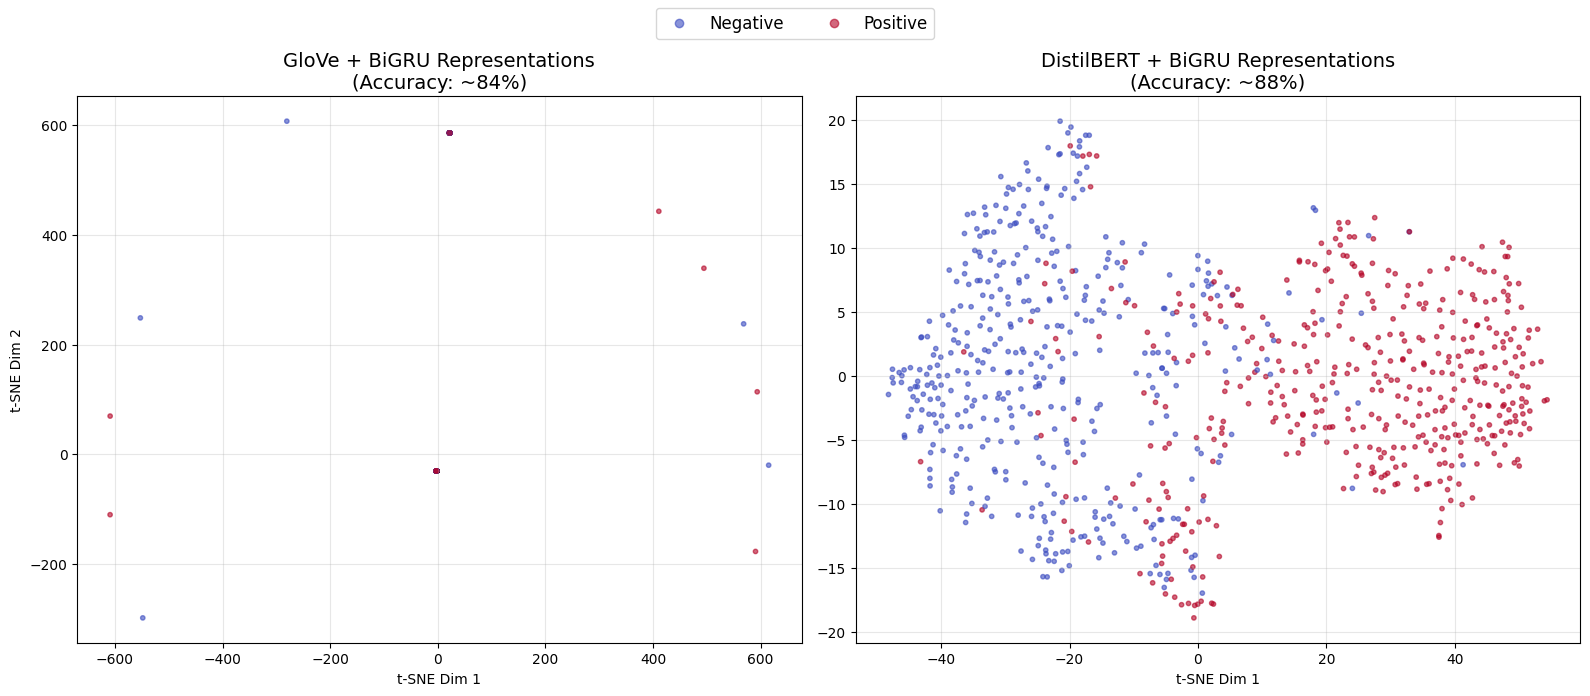

Plot saved as 'task1_tsne_comparison.png'


In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# ==========================================
# TASK 1e: VISUALIZATION (t-SNE)
# ==========================================

def get_representations(model, loader, model_name="Model"):
    """
    Validation setindeki tüm cümlelerin modelden geçirilip
    son 'hidden state' (temsil) vektörlerinin alınması.
    """
    model.eval()
    all_reps = []
    all_labels = []

    print(f"Extracting representations for {model_name}...")

    with torch.no_grad():
        for text, label in loader:
            # Modelin içindeki işlemleri tekrar ediyoruz ama son katmana (fc) girmeden duracağız
            if 'bert' in model_name.lower():
                 # BERT için maske lazım
                attention_mask = (text != tokenizer.pad_token_id).long()
                embedded = model.bert(input_ids=text, attention_mask=attention_mask)[0]
            else:
                # GloVe için direkt embedding
                embedded = model.dropout(model.embedding(text))

            # RNN'den geçir
            if model.model_type == 'lstm':
                output, (hidden, cell) = model.rnn(embedded)
            else: # gru
                output, hidden = model.rnn(embedded)

            # Son hidden state'i al (Concatenate forward & backward)
            if model.rnn.bidirectional:
                hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
            else:
                hidden_state = hidden[-1,:,:]

            all_reps.extend(hidden_state.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    return np.array(all_reps), np.array(all_labels)

# 1. Temsilleri Çıkar (GloVe vs DistilBERT)
# Sadece GRU modellerini kıyaslamak yeterli ve temiz olacaktır.
reps_glove, labels_glove = get_representations(model_gru, val_loader, "GloVe-BiGRU")
reps_bert, labels_bert = get_representations(model_bert_gru, bert_val_loader, "DistilBERT-BiGRU")

# 2. t-SNE Uygula (Boyut İndirgeme: 512 -> 2)
# Perplexity: Komşuluk sayısı (küçük veri için 30 iyidir)
print("Running t-SNE on GloVe representations...")
tsne_glove = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(reps_glove)

print("Running t-SNE on DistilBERT representations...")
tsne_bert = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(reps_bert)

# 3. Çizdir (Side-by-Side Plot)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot GloVe
scatter1 = axes[0].scatter(tsne_glove[:, 0], tsne_glove[:, 1], c=labels_glove, cmap='coolwarm', alpha=0.6, s=10)
axes[0].set_title(f'GloVe + BiGRU Representations\n(Accuracy: ~84%)', fontsize=14)
axes[0].set_xlabel('t-SNE Dim 1')
axes[0].set_ylabel('t-SNE Dim 2')
axes[0].grid(True, alpha=0.3)

# Plot DistilBERT
scatter2 = axes[1].scatter(tsne_bert[:, 0], tsne_bert[:, 1], c=labels_bert, cmap='coolwarm', alpha=0.6, s=10)
axes[1].set_title(f'DistilBERT + BiGRU Representations\n(Accuracy: ~88%)', fontsize=14)
axes[1].set_xlabel('t-SNE Dim 1')
axes[1].grid(True, alpha=0.3)

# Legend
legend_labels = ['Negative', 'Positive']
handles = scatter1.legend_elements()[0]
fig.legend(handles, legend_labels, loc='upper center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Grafiği kaydet (Rapora koymak için)
fig.savefig('task1_tsne_comparison.png', dpi=300)
print("Plot saved as 'task1_tsne_comparison.png'")